# Functions of QAOA angles

In this How-To we optimize QAOA angles in a different basis. We consider the Fourier bases as done by Zhou et al. in PRX 10, 021067 (2020). The optimization is carried out at small scale with a state vector simulator.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from qiskit import transpile
from qiskit.circuit.library import QAOAAnsatz

from qiskit_ibm_runtime import Sampler

from qiskit_aer import Aer

from qaoa_training_pipeline.evaluation import EfficientDepthOneEvaluator, StatevectorEvaluator
from qaoa_training_pipeline.training.functions import FourierFunction
from qaoa_training_pipeline.training.parameter_extenders import trivial_extend
from qaoa_training_pipeline.training import DepthOneScanTrainer, ScipyTrainer, RecursionTrainer
from qaoa_training_pipeline.utils.graph_utils import load_graph, graph_to_operator

In [2]:
graph = load_graph("../data/problems/example_graph.json")
cost_op = graph_to_operator(graph, pre_factor=-0.5)

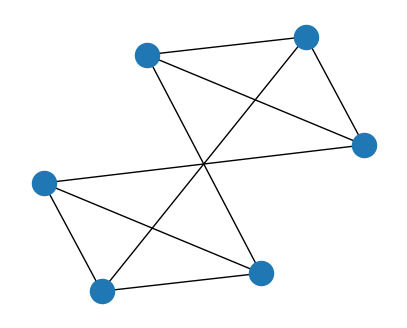

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
nx.draw_kamada_kawai(graph, ax=ax)

## 1) Vanilla optimization from a random initial point

Here, we optimize the Fourier coefficients for a depth-10 QAOA starting from a random initial point. The QAOA depth is fixed by the function `FourierFunction(depth=10)`. The number of Fourier coefficients is fixed by the initial point. In this case we have four coefficients for $\gamma$ and four coefficients for $\beta$.

In [4]:
trainer = ScipyTrainer(
    StatevectorEvaluator(),
    minimize_args={"options": {"maxiter": 500}},
    qaoa_angles_function=FourierFunction(depth=10),
)

In [5]:
result = trainer.train(cost_op, np.random.uniform(0, np.pi, 8))

The `qaoa_angles_function` in the trainer lets us plot both the QAOA angles as well as the function in the Fourier basis.

(<Figure size 1400x400 with 3 Axes>,
 <Axes: xlabel='Iteration number', ylabel='Energy'>)

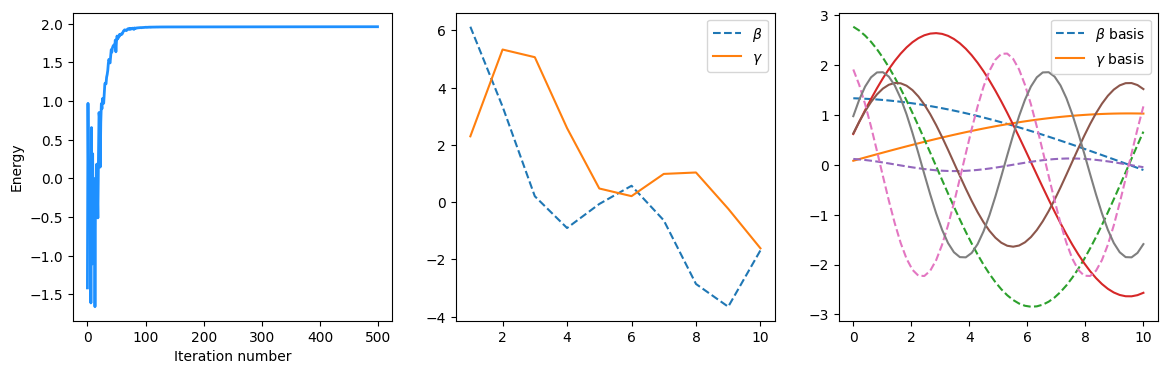

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
trainer.qaoa_angles_function.plot_angles(result["parameter_history"][-1], axs[1])
trainer.qaoa_angles_function.plot_basis(result["parameter_history"][-1], axs[2])
trainer.plot(axis=axs[0], fig=fig)

In [7]:
print(result["optimized_qaoa_angles"])

[6.127683959809643, 3.3369310070871516, 0.20604803670033167, -0.9037584538177412, -0.06396654777527766, 0.5721602832560646, -0.6350033232111421, -2.85831472455861, -3.653116457771403, -1.681827847703203, 2.2998370356209303, 5.330875012813138, 5.063121167538379, 2.5859781202331464, 0.47673047435015103, 0.20914553973151678, 0.9859216378596212, 1.03590917507534, -0.23098344371659035, -1.6130063093799965]


In [8]:
print(result["optimized_params"])

[1.3371761055119034, 2.8460082400543683, 0.12641859864246213, 2.240642231264097, 1.0294714392415973, 2.639100027509839, 1.6421887110671989, 1.8651564320250889]


## 2) Recursive optimization

In the following we recursively optimize the coefficients of the Fourier representation of the QAOA parameters. The underlying is a depth-ten 10 as indicated by
```python
FourierFunction(depth=10)
```
The recursive trainer will start from an initial point found via a depth-one scan in the Fourier basis. This will produce a good initial point $(u^\star_1, v^\star_1)$ with which to seed the recursion. The initial points at depth $p+1$ are trvially found from depth $p$ by extending the parameter vector with zeros. This is done by the `trivial_extend` function. It corresponds to extending the Fourier basis by one mode, initially set to amplitude zero.

In [9]:
angles_func = FourierFunction(depth=10)

pre_trainer = DepthOneScanTrainer(StatevectorEvaluator(), qaoa_angles_function=angles_func)

sub_trainer = ScipyTrainer(
    StatevectorEvaluator(),
    minimize_args={"options": {"maxiter": 500, "rhobeg": 0.2}},
    qaoa_angles_function=angles_func,
)

rtrainer = RecursionTrainer(sub_trainer, trivial_extend)

In [10]:
presult = pre_trainer.train(cost_op, parameter_ranges=((0, np.pi), (0, np.pi)))

In [11]:
rresult = rtrainer.train(cost_op, params0=presult["optimized_params"], reps=6)

We also prepare an optimize QAOA circuit and sample from it to show that we indeed get good samples. The optimal QAOA angles are found in `rresult["optimized_qaoa_angles"]`. Below, we observe that each level of the recusion increases the energy which is a sign of a good optimization.

In [12]:
optimal_circuit = QAOAAnsatz(cost_op, reps=len(rresult["optimized_qaoa_angles"]) // 2).decompose()
optimal_circuit.assign_parameters(rresult["optimized_qaoa_angles"], inplace=True)
optimal_circuit.measure_all()

sampler = Sampler(mode=Aer.get_backend("qasm_simulator"))
isa_circuit = transpile(optimal_circuit, basis_gates=["sx", "x", "rzz", "rz"])
sampler_result = sampler.run([isa_circuit]).result()[0].data.meas.get_counts()

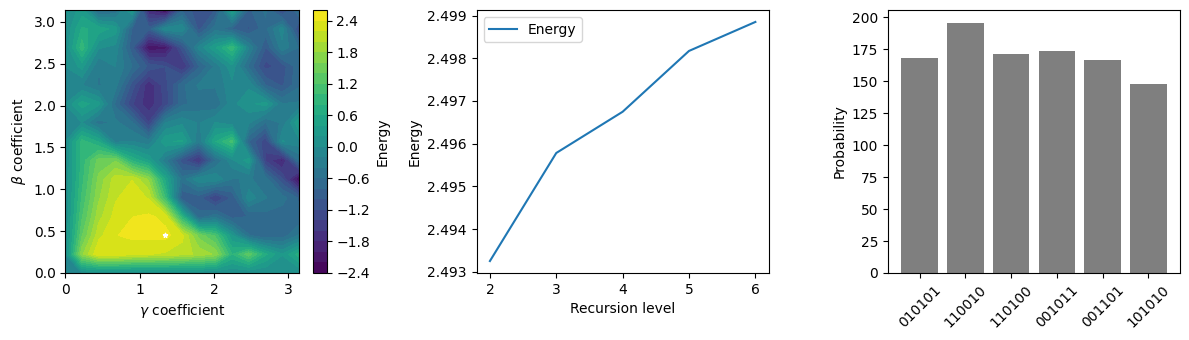

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
pre_trainer.plot(
    fig=fig, axis=axs[0], xlabel=r"$\gamma$ coefficient", ylabel=r"$\beta$ coefficient"
)
rtrainer.plot(fig=fig, axis=axs[1])
axs[2].bar(list(sampler_result.keys()), list(sampler_result.values()), color="tab:grey")
axs[2].set_ylabel("Probability")
plt.xticks(rotation=45)
plt.tight_layout()